# __Анализ конверсий пазлов (картинок)__  
Период с 01.03.22 по 05.05.22

In [2]:
import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# __Можно порпустить и перейти к ячейке [20].__  
## __Подготовительная часть - обработка, отсеивание и привидение в читаемы вид данных.__  

__Загружаем данные из файла выгрузки Яндекса__

In [3]:
data=pd.read_csv('events (2).csv')
data

,profile_id,event_name,event_json,event_datetime
0,NaN,game_puzzle_pause,"{""puzzle_id"":""23"",""Order_number"":""38"",""categor...",2022-05-03 08:51:59
1,NaN,result_window,"{""recommended_levels"":""44/20/12"",""result"":""23""...",2022-05-03 08:51:58
2,NaN,session_pause,"{""balance"":""1650"",""days_in_game"":""11"",""PuzzleC...",2022-05-03 08:51:59
3,NaN,show_interface,"{""interface"":""puzzle_finish"",""category_id"":""15...",2022-05-03 08:51:58
4,NaN,ui_screen,"{""Prev"":""GameplayScreenState"",""Next"":""TakedPic...",2022-05-03 08:51:58
...,...,...,...,...
23490741,NaN,x_take_reward,"{""balance"":""795"",""days_in_game"":""1"",""PuzzleCom...",2022-04-13 08:55:58
23490742,NaN,x_take_reward,"{""balance"":""800"",""days_in_game"":""1"",""PuzzleCom...",2022-04-13 09:00:10
23490743,NaN,x_take_reward,"{""balance"":""805"",""days_in_game"":""1"",""PuzzleCom...",2022-04-13 09:03:37
23490744,NaN,x_take_reward,"{""balance"":""810"",""days_in_game"":""1"",""PuzzleCom...",2022-04-13 09:06:44


In [4]:
# в процессе исследования был полезен датасет "в сборе"
# data_full = pd.concat([data[['event_name', 'event_datetime']],data_json], axis=1)

__Все значения чтолбца event_name (77 значений)__

In [5]:
data['event_name'].value_counts()[0:77]

video_ads_available      9457187
show_image               3189704
ui_element               1415386
ui_screen                1209426
show_interface           1084116
                          ...   
complete_achievement         507
remote_config_timeout        414
iap_purchase                 302
iap_purchase_invalid         234
iap_purchase_valid            22
Name: event_name, Length: 77, dtype: int64

__Любопытно, что лежит в event_name == 'data_info'__ (пока ничего интересного)

In [6]:
data_info=data[data['event_name']=='data_info']
data_info_json = pd.json_normalize(list(map(json.loads, data_info.event_json)))
data_info_json.head(10)

,Memory,CoreCount,CoreFrequency,ResolutionH,ResolutionW,Resolution,ScreenW,ScreenH,ScreenD,Screen,UTC,Version,MCC,balance,days_in_game,PuzzleComplete,PuzzleStart
0,2476,8,2002,1920,1200,1200x1920,5,8,9_433981,5x8,-7,1_4_1,,500,0,0,0
1,958,4,1300,1024,600,600x1024,2_5,4_266667,4_945144,2_5x4_266667,2,1_4_1,60600,500,0,0,0
2,3788,8,2362,2160,1080,1080x2160,"2,25","4,5","5,031153","2,25x4,5",-5,1_4_1,732111,500,0,0,0
3,2787,8,2301,1520,720,720x1520,"2,25","4,75","5,255949","2,25x4,75",1,1_4_1,60503,500,0,0,0
4,5440,8,2208,2400,1080,1080x2400,2_25,5,5_482928,2_25x5,-6,1_4_1,302370,500,0,0,0
5,11360,8,2841,1656,1326,1326x1656,4_209524,5_257143,6_734808,4_209524x5_257143,-6,1_4_1,310260,500,0,0,0
6,2837,6,0,1792,828,828x1792,"2,539877","5,496933","6,055348","2,539877x5,496933",2,1_4,NaN,500,0,0,0
7,2725,8,1560,1560,720,720x1560,"2,25","4,875","5,369183","2,25x4,875",1,1_4_3,60502,0,0,0,0
8,1977,2,0,2048,1536,1536x2048,"5,818182","7,757576","9,69697","5,818182x7,757576",11,1_4,NaN,500,0,0,0
9,2905,6,0,2224,1668,1668x2224,6_318182,8_424242,10_5303,6_318182x8_424242,-4,1_4,NaN,500,0,0,0


__Оставляем только интересующие нас события/event_name, связанные с пазлами, а именно:__  
show_image  
game_puzzle_start  
game_puzzle_complete  
game_puzzle_quit  
game_puzzle_concat  
game_puzzle_receive  
game_puzzle_click  
game_puzzle_start_continue  
  
 


In [7]:
data=data[data['event_name'].isin(['show_image', 'game_puzzle_start', 'game_puzzle_complete', 'game_puzzle_quit', 'game_puzzle_concat', 'game_puzzle_receive', 'game_puzzle_click', 'game_puzzle_start_continue'])].reset_index(drop=True)
data

,profile_id,event_name,event_json,event_datetime
0,NaN,game_puzzle_click,"{""category_id"":""7"",""puzzle_id"":""78"",""Order_num...",2022-05-04 08:10:51
1,NaN,game_puzzle_click,"{""category_id"":""7"",""puzzle_id"":""78"",""Order_num...",2022-05-04 08:26:51
2,NaN,game_puzzle_click,"{""category_id"":""7"",""puzzle_id"":""78"",""Order_num...",2022-05-04 08:50:23
3,NaN,game_puzzle_click,"{""category_id"":""7"",""puzzle_id"":""78"",""Order_num...",2022-05-04 09:18:12
4,NaN,game_puzzle_click,"{""category_id"":""13"",""puzzle_id"":""7"",""Order_num...",2022-05-04 09:19:46
...,...,...,...,...
4260547,NaN,show_image,"{""category_id"":""23"",""puzzle_id"":""51"",""Order_nu...",2022-04-13 18:01:23
4260548,NaN,show_image,"{""category_id"":""21"",""puzzle_id"":""3"",""Order_num...",2022-04-13 18:01:23
4260549,NaN,show_image,"{""category_id"":""35"",""puzzle_id"":""16"",""Order_nu...",2022-04-13 18:00:56
4260550,NaN,show_image,"{""category_id"":""21"",""puzzle_id"":""83"",""Order_nu...",2022-04-13 18:01:01


__Уберем дубликаты__ (не понятна их природа, но они есть... при последующем сравнении данных, оказалось что "дубликаты" важны)

In [8]:
#data.drop_duplicates(inplace=True)

__Вынимаем из data.event_json информацию в читаемый/преобразуемый вид__   

In [9]:
data_json = pd.json_normalize(list(map(json.loads, data.event_json)))
data_json.head(30)

,category_id,puzzle_id,Order_number,is_purchased,place,balance,days_in_game,PuzzleComplete,PuzzleStart,Rotate,...,completed,background,Progress,Continue,started,available,Percent,Concat,Placed,puzzle_uid
0,7,78,73,True,daily,1850,12,23,37,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,78,73,True,daily,1850,12,23,38,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,78,73,True,inprogress,1850,12,23,39,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7,78,73,True,inprogress,1850,13,23,40,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13,7,7,False,inprogress,1885,13,24,41,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,13,7,7,True,daily,1885,13,24,42,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,13,7,7,True,inprogress,1885,13,24,43,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,23,2,0,True,inprogress,1990,13,25,44,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,23,2,0,True,daily,1990,13,25,45,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,23,2,0,True,inprogress,1990,13,25,46,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# значения столбца 'place'
data_json.place.value_counts()

daily            2291331
category         1413606
in_progress       221162
inprogress        146721
free_category      96015
completed          75971
none               15413
Name: place, dtype: int64

__Формируем dataframe c событиями и пазлами. Добавляем столбец puzz_cat_id, который будет однозначно идентифицировать puzzle_id. В нем: IDпазла_IDкатегории.__

In [11]:
data_work = data[['event_name', 'event_datetime']]
data_work['puzz_cat_id'] = data_json.puzzle_id.astype(str) + '_' + data_json.category_id.astype(str)
data_work['place'] = data_json['place']

C:\Users\sorok\AppData\Local\Temp/ipykernel_100564/3077357097.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work['puzz_cat_id'] = data_json.puzzle_id.astype(str) + '_' + data_json.category_id.astype(str)


In [12]:
data_work

,event_name,event_datetime,puzz_cat_id,place
0,game_puzzle_click,2022-05-04 08:10:51,78_7,daily
1,game_puzzle_click,2022-05-04 08:26:51,78_7,daily
2,game_puzzle_click,2022-05-04 08:50:23,78_7,inprogress
3,game_puzzle_click,2022-05-04 09:18:12,78_7,inprogress
4,game_puzzle_click,2022-05-04 09:19:46,7_13,inprogress
...,...,...,...,...
4260547,show_image,2022-04-13 18:01:23,51_23,daily
4260548,show_image,2022-04-13 18:01:23,3_21,daily
4260549,show_image,2022-04-13 18:00:56,16_35,daily
4260550,show_image,2022-04-13 18:01:01,83_21,daily


In [13]:
show_image = data_work.query('event_name=="show_image"').groupby(by='puzz_cat_id').count().iloc[:,2:4]
show_image.rename(columns={'place':'show_image'}, inplace=True)
show_image.reset_index(inplace=True)

__Формируем фреймы с подсчетами участия пазлов, по событиям.__

In [14]:
show_image = data_work.query('event_name=="show_image"').groupby(by='puzz_cat_id').count().iloc[:,2:4]
show_image.rename(columns={'place':'show_image'}, inplace=True)
show_image.reset_index(inplace=True)

game_puzzle_start = data_work.query('event_name=="game_puzzle_start"').groupby(by='puzz_cat_id').count().iloc[:,2:4]
game_puzzle_start.rename(columns={'place':'game_puzzle_start'}, inplace=True)
game_puzzle_start.reset_index(inplace=True)

game_puzzle_complete = data_work.query('event_name=="game_puzzle_complete"').groupby(by='puzz_cat_id').count().iloc[:,2:4]
game_puzzle_complete.rename(columns={'place':'game_puzzle_complete'}, inplace=True)
game_puzzle_complete.reset_index(inplace=True)

game_puzzle_quit = data_work.query('event_name=="game_puzzle_quit"').groupby(by='puzz_cat_id').count().iloc[:,2:4]
game_puzzle_quit.rename(columns={'place':'game_puzzle_quit'}, inplace=True)
game_puzzle_quit.reset_index(inplace=True)

__Вот они:__

In [15]:
show_image.head(3)

,puzz_cat_id,show_image
0,100_1,1621
1,100_31,2508
2,10_1,3206


In [16]:
game_puzzle_start.head(3)

,puzz_cat_id,game_puzzle_start
0,100_1,79
1,100_31,113
2,10_1,130


In [17]:
game_puzzle_complete.head(3)

,puzz_cat_id,game_puzzle_complete
0,100_1,71
1,100_31,114
2,10_1,117


In [18]:
game_puzzle_quit.head(3)

,puzz_cat_id,game_puzzle_quit
0,100_1,1
1,100_31,6
2,10_1,8


In [19]:
# есть странный пазл '38_23', который 800+ раз учавствовал в показах, но ни разу не стартовал и не копмплитил
print(list(set(show_image['puzz_cat_id']) ^ set(game_puzzle_complete['puzz_cat_id'])))
# откажемся от него
show_image = show_image.query('puzz_cat_id != "38_23"').reset_index(drop=True)

['38_23']


# __Работа с конверсиями и событиями по пазлам (без деления на daily, category).__

#### __Объединим фреймы в один и посчитаем конверсии по пазлам. (обращаем внимание - есть странные конверсии > 100%)__

In [20]:
data_count_all = show_image.merge(game_puzzle_start, how='left').merge(game_puzzle_complete, how='left').merge(game_puzzle_quit, how='left')

In [21]:
data_count_all['conv_show_to_start'] = round (data_count_all['game_puzzle_start'] / data_count_all['show_image'] * 100, 2)
data_count_all['conv_show_to_complete'] = round (data_count_all['game_puzzle_complete'] / data_count_all['show_image'] * 100, 2)
data_count_all['conv_start_to_complete'] = round (data_count_all['game_puzzle_complete'] / data_count_all['game_puzzle_start'] * 100, 2)
data_count_all['conv_start_to_quit'] = round (data_count_all['game_puzzle_quit'] / data_count_all['game_puzzle_start'] * 100, 2)
data_count_all = data_count_all.fillna(0)
data_count_all

,puzz_cat_id,show_image,game_puzzle_start,game_puzzle_complete,game_puzzle_quit,conv_show_to_start,conv_show_to_complete,conv_start_to_complete,conv_start_to_quit
0,100_1,1621,79,71,1.0,4.87,4.38,89.87,1.27
1,100_31,2508,113,114,6.0,4.51,4.55,100.88,5.31
2,10_1,3206,130,117,8.0,4.05,3.65,90.00,6.15
3,10_10,1917,71,56,14.0,3.70,2.92,78.87,19.72
4,10_11,2353,65,53,8.0,2.76,2.25,81.54,12.31
...,...,...,...,...,...,...,...,...,...
1329,9_37,2957,117,95,29.0,3.96,3.21,81.20,24.79
1330,9_4,1934,77,72,4.0,3.98,3.72,93.51,5.19
1331,9_6,2190,102,87,13.0,4.66,3.97,85.29,12.75
1332,9_7,1930,71,62,6.0,3.68,3.21,87.32,8.45


#### __Гистограммы конверсий__

Text(0.5, 1.0, 'Конверсия satrt to quit')

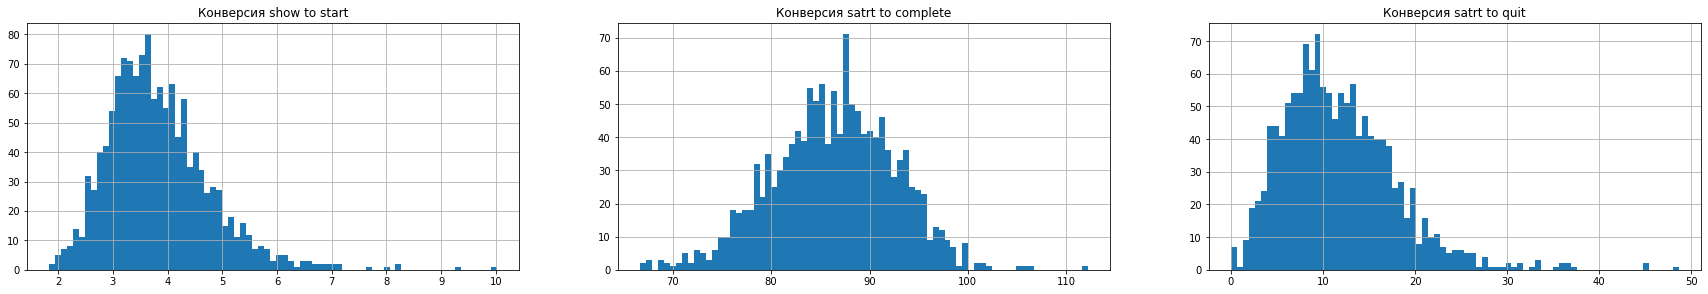

In [22]:
plt.figure(figsize=(30, 10))
plt.subplot(2, 3, 1)
data_count_all['conv_show_to_start'].hist(bins=75)
plt.title("Конверсия show to start")

plt.subplot(2, 3, 2)
data_count_all['conv_start_to_complete'].hist(bins=75)
plt.title("Конверсия satrt to complete")

plt.subplot(2, 3, 3)
data_count_all['conv_start_to_quit'].hist(bins=75)
plt.title("Конверсия satrt to quit")

#### __Гистограммы событий__.  
__Любопытны пазлы с "зашкаливающими" значениями, когда и если будет информация по неизвестным признакам, можно порассматривать их.__

Text(0.5, 1.0, 'game_puzzle_complete')

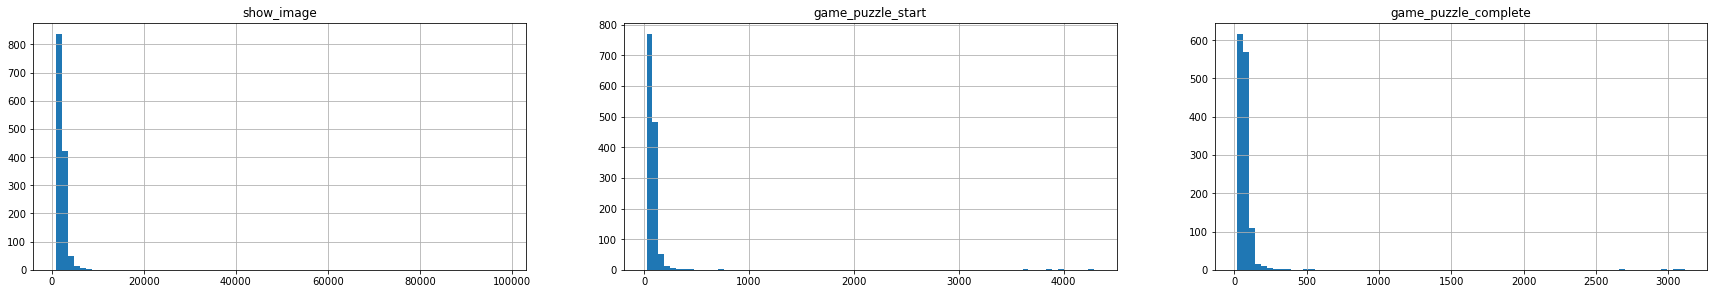

In [59]:
plt.figure(figsize=(30, 10))
plt.subplot(2, 3, 1)
data_count_all['show_image'].hist(bins=75)
plt.title("show_image")

plt.subplot(2, 3, 2)
data_count_all['game_puzzle_start'].hist(bins=75)
plt.title("game_puzzle_start")

plt.subplot(2, 3, 3)
data_count_all['game_puzzle_complete'].hist(bins=75)
plt.title("game_puzzle_complete")

#### Пример таблицы с сортировкой по признаку конверсии SHOW to START

In [208]:
data_count_all.sort_values('conv_show_to_start', ascending=False).head(15)

,puzz_cat_id,show_image,game_puzzle_start,game_puzzle_complete,game_puzzle_quit,conv_show_to_start,conv_show_to_complete,conv_start_to_complete,conv_start_to_quit
1302,99_1,7322,734,508,133.0,10.02,6.94,69.21,18.12
1287,91_31,1069,100,97,2.0,9.35,9.07,97.00,2.00
1295,95_31,1066,88,75,3.0,8.26,7.04,85.23,3.41
1099,64_1,8817,722,552,113.0,8.19,6.26,76.45,15.65
1010,53_1,1489,119,111,7.0,7.99,7.45,93.28,5.88
668,31_1,1115,86,84,3.0,7.71,7.53,97.67,3.49
787,39_1,948,68,57,5.0,7.17,6.01,83.82,7.35
1252,89_31,1664,119,114,15.0,7.15,6.85,95.80,12.61
316,1_31,6515,460,375,78.0,7.06,5.76,81.52,16.96
262,18_35,2872,201,155,33.0,7.00,5.40,77.11,16.42


#### Пример таблицы с сортировкой по признаку конверсии START to COMPLETE

In [207]:
data_count_all.sort_values('conv_start_to_complete', ascending=False).head(15)

,puzz_cat_id,show_image,game_puzzle_start,game_puzzle_complete,game_puzzle_quit,conv_show_to_start,conv_show_to_complete,conv_start_to_complete,conv_start_to_quit
638,2_7,1163,41,46,1.0,3.53,3.96,112.20,2.44
179,15_7,1160,32,34,2.0,2.76,2.93,106.25,6.25
1122,69_7,1038,34,36,1.0,3.28,3.47,105.88,2.94
550,27_4,1833,58,61,3.0,3.16,3.33,105.17,5.17
1009,52_7,1626,43,44,3.0,2.64,2.71,102.33,6.98
90,12_7,1811,55,56,1.0,3.04,3.09,101.82,1.82
992,50_7,1943,65,66,6.0,3.35,3.40,101.54,9.23
1189,79_1,2924,83,84,7.0,2.84,2.87,101.20,8.43
1,100_31,2508,113,114,6.0,4.51,4.55,100.88,5.31
1234,83_31,1571,79,79,7.0,5.03,5.03,100.00,8.86


#### Пример таблицы с сортировкой по признаку COMPLETE  
Любопытна природа больших цифр первых трех пазлов, когда и если будет информация по неизвестным признакам, можно порассматривать их.

In [209]:
data_count_all.sort_values('game_puzzle_complete', ascending=False).head(15)

,puzz_cat_id,show_image,game_puzzle_start,game_puzzle_complete,game_puzzle_quit,conv_show_to_start,conv_show_to_complete,conv_start_to_complete,conv_start_to_quit
698,33_1,98026,3991,3117,558.0,4.07,3.18,78.10,13.98
814,3_21,88382,4290,3051,794.0,4.85,3.45,71.12,18.51
1272,8_31,94544,3869,2952,541.0,4.09,3.12,76.30,13.98
319,1_34,93294,3647,2700,682.0,3.91,2.89,74.03,18.70
1099,64_1,8817,722,552,113.0,8.19,6.26,76.45,15.65
1302,99_1,7322,734,508,133.0,10.02,6.94,69.21,18.12
316,1_31,6515,460,375,78.0,7.06,5.76,81.52,16.96
722,34_31,6156,398,331,75.0,6.47,5.38,83.17,18.84
773,38_1,8574,375,329,35.0,4.37,3.84,87.73,9.33
669,31_12,5173,342,280,63.0,6.61,5.41,81.87,18.42


#### __Оценим нормальность распределения значений конверсии start to complete__

Воспользуемся тестом Шапиро-Уилка для оценки нормальности распределения значений конверсии start to complete.  
H0 - распределение нормальное  
H1 - распределение другое  
Statistics=0.942, p-value=0.00000  
На уровне значисомти 0.05 отвергаем нулевую гипотезу. Распределение не является нормальным.  
(логарифмирование вытягивает p-value до 0.002, но не помогает)

In [25]:
import scipy
stat, p = scipy.stats.shapiro(list(data_count_all['conv_show_to_start'])) # тест Шапиро-Уилк
print('Statistics=%.3f, p-value=%.5f' % (stat, p))

Statistics=0.942, p-value=0.00000


Любытно, построим qq-plot.  
(очень похоже на нормальное, но видимо все-таки нет...)

c:\Users\sorok\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


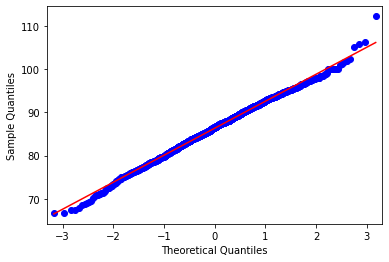

In [26]:
from statsmodels.graphics.gofplots import qqplot
qqplot(data_count_all['conv_start_to_complete'], line='s')
plt.show()

#### __Расчитаем среднее, медиану, диспресию и доверительный интервал для конверсии start to complete__
смущает ненормальность... но пока не знаю что с этим можно сделать и нужно ли, пробовал bootstrap, он практически не меняет результатов...

In [129]:
mean, sigma = np.mean(list(data_count_all['conv_start_to_complete'])), np.std(list(data_count_all['conv_start_to_complete']))
conf_int = stats.norm.interval(0.95, loc=mean, scale=sigma)

print('Среднее для конверсии start to complete ', round(data_count_all['conv_start_to_complete'].mean(),2))
print('Медиана для конверсии start to complete ', round(data_count_all['conv_start_to_complete'].median(),2))
print('Дисперсия для конверсии start to complete ', round(np.var(data_count_all['conv_start_to_complete']),2))
print('Стандартное отклонение для конверсии start to complete ', round(np.std(data_count_all['conv_start_to_complete']),2))
print('95% доверительный интервал для конверсии --/-- ', list(np.round(conf_int,2)))

Среднее для конверсии start to complete  86.33
Медиана для конверсии start to complete  86.54
Дисперсия для конверсии start to complete  38.9
Стандартное отклонение для конверсии start to complete  6.24
95% доверительный интервал для конверсии --/--  [74.1, 98.55]


Text(0.5, 1.0, '95% Confidence interval of conv_start_to_complete')

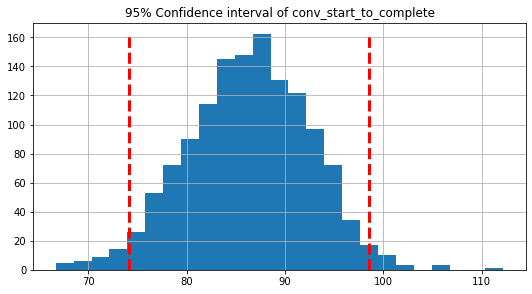

In [131]:
plt.figure(figsize=(30, 10))
plt.subplot(2, 3, 1)
data_count_all['conv_start_to_complete'].hist(bins=25)
plt.vlines(conf_int[0],0,160, colors='red', linewidth = 3, linestyles='--')
plt.vlines(conf_int[1],0,160, colors='red', linewidth = 3, linestyles='--')
plt.title("95% Confidence interval of conv_start_to_complete")


#### __Посмотрим на выбросы левого/нижнего хвоста__   
1. Наблюдаем пазлы с низкой конверсией start to complete и одновременно высокой конверсией start to quit (медианное  значение - 10.84) 
2. Из общей картины выбиваются пазлы 1_34 и 3_21, по ним высокие цыфры show_image, выше средней конверсия show to start, но высокая конверсяи start to quit. Экземпляры любопытны тем что набрали высокие значения по показам, очень интересно как это произошло.


In [53]:
data_count_all[data_count_all['conv_start_to_complete']<74.1]

,puzz_cat_id,show_image,game_puzzle_start,game_puzzle_complete,game_puzzle_quit,conv_show_to_start,conv_show_to_complete,conv_start_to_complete,conv_start_to_quit
14,10_21,1212,38,28,3.0,3.14,2.31,73.68,7.89
53,11_33,2332,89,64,12.0,3.82,2.74,71.91,13.48
73,12_20,1553,67,47,15.0,4.31,3.03,70.15,22.39
76,12_24,2481,135,98,25.0,5.44,3.95,72.59,18.52
89,12_6,2012,85,59,16.0,4.22,2.93,69.41,18.82
127,14_14,2313,83,59,14.0,3.59,2.55,71.08,16.87
153,15_10,2042,75,53,14.0,3.67,2.60,70.67,18.67
194,16_23,1369,53,38,5.0,3.87,2.78,71.70,9.43
195,16_24,2203,77,55,15.0,3.50,2.50,71.43,19.48
270,19_11,2360,51,34,13.0,2.16,1.44,66.67,25.49


#### __Посмотрим на выбросы правого/верхнего хвоста__  
1. Наблюдаем пазлы с конверсией start to complete более 98,5%, со "средним/обычным", если так можно говорить, количеством показов.
2. Любопытно как измениться конверсия start to complite при увеличении количества показов.


In [54]:
data_count_all[data_count_all['conv_start_to_complete']>98.55]

,puzz_cat_id,show_image,game_puzzle_start,game_puzzle_complete,game_puzzle_quit,conv_show_to_start,conv_show_to_complete,conv_start_to_complete,conv_start_to_quit
1,100_31,2508,113,114,6.0,4.51,4.55,100.88,5.31
55,11_35,1257,36,36,2.0,2.86,2.86,100.00,5.56
90,12_7,1811,55,56,1.0,3.04,3.09,101.82,1.82
179,15_7,1160,32,34,2.0,2.76,2.93,106.25,6.25
461,24_31,1690,81,80,5.0,4.79,4.73,98.77,6.17
550,27_4,1833,58,61,3.0,3.16,3.33,105.17,5.17
638,2_7,1163,41,46,1.0,3.53,3.96,112.20,2.44
677,31_31,2638,111,111,5.0,4.21,4.21,100.00,4.50
897,45_18,1412,51,51,2.0,3.61,3.61,100.00,3.92
940,48_7,1420,41,41,3.0,2.89,2.89,100.00,7.32


#### __Гипотеза 1__  
1. Найдем 95% доверительный интервал для среднего значения конверсии start to complete.  
2. Выделим подвыборку пазлов, конверсии которых, попадают в п.1.  
3. Найдем среднее значение complete для подвыборки из п.2.  
4. Станем утверждать, что пазлы набравшие complete >= среднему из п.3 при этом имеющие низкую конверсию (не попадающие в доверительный интервал конверсии), не интересны пользователю.

Найдем 95% доверительный интервал для среднего значения конверсии start to complete

In [136]:
mean, sigma = np.mean(list(data_count_all['conv_start_to_complete'])), np.std(list(data_count_all['conv_start_to_complete']))
conf_int = stats.norm.interval(0.95, loc=mean, scale=sigma/np.sqrt(len(list(data_count_all['conv_start_to_complete']))))

print('Среднее значение для конверсии start to complete ', round(mean,2))
print('95% доверительный интервал для среднего значения конверсии start to complete ', list(np.round(conf_int,2)))

Среднее значение для конверсии start to complete  86.33
95% доверительный интервал для среднего значения конверсии start to complete  [85.99, 86.66]


Посмотрим какое количество completе'ов приходится на найденное на средние значения (из найденного доверительного интервала) конверсии start to complete

<AxesSubplot:>

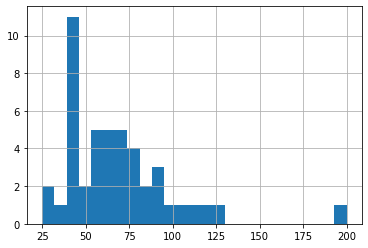

In [197]:
# гистограмма распределения complete'ов среди средних конверсий start to complete
data_count_all.query('conv_start_to_complete>@conf_int[0] and conv_start_to_complete<@conf_int[1]').game_puzzle_complete.hist(bins=25)

Найдем среднее complete для среднего по конверсии start to complete, восопльзуемся bootstrap

In [202]:
# воспользуемся bootstrap
boot_it = 1000 # количсетво бустрап подвыборок
boot_len = 100 # объем сэмплирования
boot_data = []
for i in range(boot_it): # извлекаем подвыборки
    samples = list(data_count_all['conv_start_to_complete'].sample(boot_len, replace = True).values)
    boot_data.append(round(np.mean(samples),2))

# гистограмма средних из бутстрапа
#pd_boot_data = pd.DataFrame(boot_data)
#pd_boot_data.hist(bins=25)

In [203]:
print('Среднее значение complete для средних конверсий start to complete', round(np.mean(boot_data)))

Среднее значение complete для средних конверсий start to complete 86


#### __Т.е. мы говорим о том что, если наш пазл набрал 86 complete и при этом его конверсия не попадает в доверительный интервал конверсии по всем пазлам, такой пазл не интересен пользователю.__

#### __Результаты.__
1. Расчитан 95% доверительный интервал для значений конверсии start to complete.  
2. Определены выбросы (левые/малые значения - выбросы, с правыми нужно/можно разбираться).
3. Предложена методика поиска неинтересных пазлов (можно играть/менять цифры интервалов и значений)

#### __Вопросы себе/тебе:__  
1. Какие еще могут быть/есть события с пазлом, кроме start, complete, quit ? Почему не бьется математика: complete + quit != start  
2. Что происходит если пользователь начинает пазл, но например приходит входящий звонок, он отвлекается и возвращаяется к нему пазлу/игре на следующий день ? Это фиксируется как quit ? 
3. Как фиксируется "брошенный" пазл ? Пользователь начал, бросил/отвлекся, на следующий день начал другой.... (по нему случился start и не случился complete !?)
4. Можно ли объяснить природу конверсии старта в комплит более 100% тем, что 100+ дают пазлы начатые до отчетного периода и законченые во время него ?
5. В исходном датафрейме есть дубликаты (одинаковые строки), если от них сразу отказаться, то картина становится вообще безумной, около 25% конверсий становятся более 100%. Какова может быть природа дубликатов ?  
6. Нужны пояснения по столбцу 'place', в каких случаях какие значения принимает. 
7. Что такое столбец 'Order_number'? (меняется в диапазоне 0..100 + есть значение 99999)  
8. Что такое 'days_in_game','PuzzleComplete','PuzzleStart' - применительно к пользователю, сколько он в игре, сколько собрал и сколько стартов пазлов было ?  
9. Нужны пояснения по столбу 'completed'?
10. Можем ли мы как-то, как в гугле, идентифицировать пользователя (user_id)